In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os, gc

import warnings; warnings.filterwarnings('ignore')

In [ ]:
user_file_list = os.listdir('/content/drive/My Drive/Archived users/')
user_set_v1 = set(map(lambda x: x[5: 15], user_file_list)) # [5: 15] to return just the user IDs


tappy_file_list = os.listdir('/content/drive/My Drive/Tappy Data/')
user_set_v2 = set(map(lambda x: x[: 10], tappy_file_list)) # [: 10] to return just the user IDs


user_set = user_set_v1.intersection(user_set_v2)

len(user_set)

217

In [ ]:
def read_user_file(file_name):
    f = open('/content/drive/My Drive/Archived users/' + file_name)
    data = [line.split(': ')[1][: -1] for line in f.readlines()]
    f.close()

    return data

In [ ]:
files = os.listdir('/content/drive/My Drive/Archived users/')

columns = [
    'BirthYear', 'Gender', 'Parkinsons', 'Tremors', 'DiagnosisYear',
    'Sided', 'UPDRS', 'Impact', 'Levadopa', 'DA', 'MAOB', 'Other'
]

user_df = pd.DataFrame(columns=columns) # empty Data Frame for now

for user_id in user_set:
    temp_file_name = 'User_' + user_id + '.txt' # tappy file names have the format of `User_[UserID].txt`
    if temp_file_name in files: # check to see if the user ID is in our valid user set
        temp_data = read_user_file(temp_file_name)
        user_df.loc[user_id] = temp_data # adding data to our DataFrame

user_df.head()

,BirthYear,Gender,Parkinsons,Tremors,DiagnosisYear,Sided,UPDRS,Impact,Levadopa,DA,MAOB,Other
K2VMDST8HC,1954,Male,True,False,2015,Left,Don't know,Mild,False,True,True,False
T0RR5A7EFV,1943,Male,True,True,2015,Left,Don't know,Medium,True,False,False,False
QEYNMBJ8T0,1940,Male,True,False,2009,None,Don't know,Severe,True,False,False,False
B4NL4SV9ZC,1941,Female,True,False,2016,None,Don't know,Severe,True,False,False,False
ZYWLN4JVLA,,Female,True,False,,Right,Don't know,Medium,True,True,True,True


In [ ]:
user_df['BirthYear'] = pd.to_numeric(user_df['BirthYear'], errors='coerce')
user_df['DiagnosisYear'] = pd.to_numeric(user_df['DiagnosisYear'], errors='coerce')

In [ ]:
user_df = user_df.rename(index=str, columns={'Gender': 'Female'}) # renaming `Gender` to `Female`
user_df['Female'] = user_df['Female'] == 'Female' # change string data to boolean data
user_df['Female'] = user_df['Female'].astype(int) # change boolean data to binary data

In [ ]:
str_to_bin_columns = ['Parkinsons', 'Tremors', 'Levadopa', 'DA', 'MAOB', 'Other'] # columns to be converted to binary data

for column in str_to_bin_columns:
    user_df[column] = user_df[column] == 'True'
    user_df[column] = user_df[column].astype(int)

In [ ]:
# prior processing for `Impact` column
user_df.loc[
    (user_df['Impact'] != 'Medium') &
    (user_df['Impact'] != 'Mild') &
    (user_df['Impact'] != 'Severe'), 'Impact'] = 'None'

to_dummy_column_indices = ['Sided', 'UPDRS', 'Impact'] # columns to be one-hot encoded
for column in to_dummy_column_indices:
    user_df = pd.concat([
        user_df.iloc[:, : user_df.columns.get_loc(column)],
        pd.get_dummies(user_df[column], prefix=str(column)),
        user_df.iloc[:, user_df.columns.get_loc(column) + 1 :]
    ], axis=1)

user_df.head()

,BirthYear,Female,Parkinsons,Tremors,DiagnosisYear,Sided_Left,Sided_None,Sided_Right,UPDRS_1,UPDRS_2,UPDRS_3,UPDRS_4,UPDRS_Don't know,Impact_Medium,Impact_Mild,Impact_None,Impact_Severe,Levadopa,DA,MAOB,Other
K2VMDST8HC,1954.0,0,1,0,2015.0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0
T0RR5A7EFV,1943.0,0,1,1,2015.0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
QEYNMBJ8T0,1940.0,0,1,0,2009.0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0
B4NL4SV9ZC,1941.0,1,1,0,2016.0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0
ZYWLN4JVLA,NaN,1,1,0,NaN,0,0,1,0,0,0,0,1,1,0,0,0,1,1,1,1


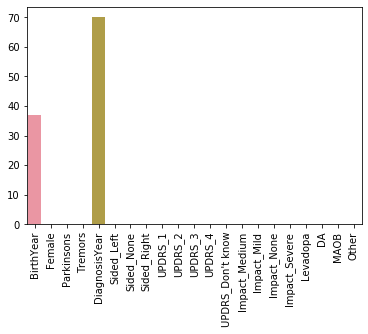

In [ ]:
missing_data = user_df.isnull().sum()

g = sns.barplot(missing_data.index, missing_data)
g.set_xticklabels(labels=missing_data.index, rotation=90)

plt.show()

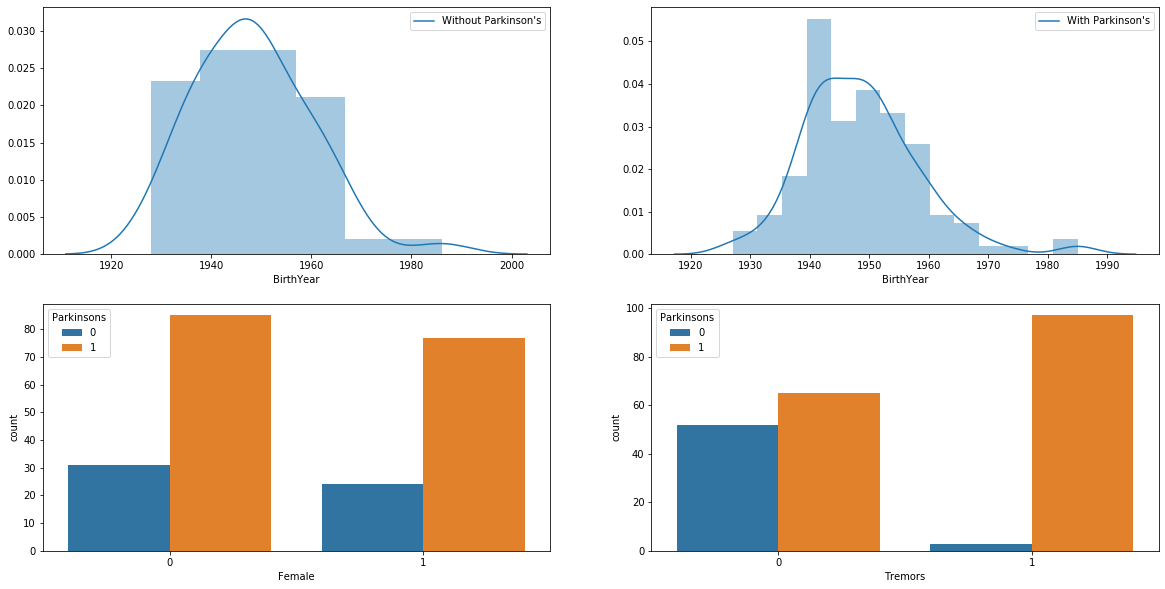

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(20, 10))

sns.distplot(
    user_df.loc[user_df['Parkinsons'] == 0, 'BirthYear'].dropna(axis=0),
    kde_kws = {'label': "Without Parkinson's"},
    ax = ax[0][0]
)
sns.distplot(
    user_df.loc[user_df['Parkinsons'] == 1, 'BirthYear'].dropna(axis=0),
    kde_kws = {'label': "With Parkinson's"},
    ax = ax[0][1]
)

sns.countplot(x='Female', hue='Parkinsons', data=user_df, ax=ax[1][0])
sns.countplot(x='Tremors', hue='Parkinsons', data=user_df, ax=ax[1][1])

plt.show()

In [ ]:
user_df.columns

Index(['BirthYear', 'Female', 'Parkinsons', 'Tremors', 'DiagnosisYear',
       'Sided_Left', 'Sided_None', 'Sided_Right', 'UPDRS_1', 'UPDRS_2',
       'UPDRS_3', 'UPDRS_4', 'UPDRS_Don't know', 'Impact_Medium',
       'Impact_Mild', 'Impact_None', 'Impact_Severe', 'Levadopa', 'DA', 'MAOB',
       'Other'],
      dtype='object')

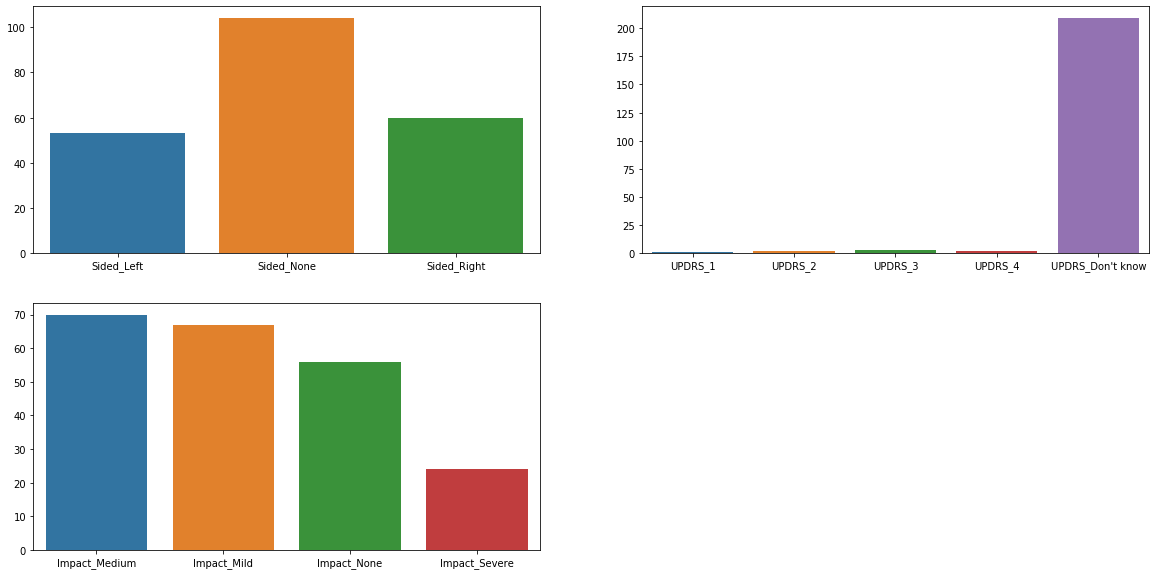

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(20, 10))

sns.barplot(
    ['Sided_Left', 'Sided_None', 'Sided_Right'],
    user_df[['Sided_Left', 'Sided_None', 'Sided_Right']].sum(),
    ax=ax[0][0]
)
sns.barplot(
    ['UPDRS_1', 'UPDRS_2', 'UPDRS_3', 'UPDRS_4', "UPDRS_Don't know"],
    user_df[['UPDRS_1', 'UPDRS_2', 'UPDRS_3', 'UPDRS_4', "UPDRS_Don't know"]].sum(),
    ax=ax[0][1]
)
sns.barplot(
    ['Impact_Medium', 'Impact_Mild', 'Impact_None', 'Impact_Severe'],
    user_df[['Impact_Medium', 'Impact_Mild', 'Impact_None', 'Impact_Severe']].sum(),
    ax=ax[1][0]
)
ax[1][1].axis('off')

plt.show()

In [ ]:
file_name = '0EA27ICBLF_1607.txt' # an arbitrary file to explore

In [ ]:
df = pd.read_csv(
    '/content/drive/My Drive/Tappy Data/' + file_name,
    delimiter = '\t',
    index_col = False,
    names = ['UserKey', 'Date', 'Timestamp', 'Hand', 'Hold time', 'Direction', 'Latency time', 'Flight time']
)

df = df.drop('UserKey', axis=1)

df.head()

,Date,Timestamp,Hand,Hold time,Direction,Latency time,Flight time
0,160722,18:41:04.336,L,0101.6,LL,0234.4,0156.3
1,160722,18:42:14.070,L,0085.9,LL,0437.5,0359.4
2,160722,18:42:14.273,L,0078.1,LL,0210.9,0125.0
3,160722,18:42:14.617,L,0062.5,LL,0359.4,0281.3
4,160722,18:42:15.586,S,0125.0,LS,0187.5,0093.8


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%y%M%d').dt.date
# converting time data to numeric
for column in ['Hold time', 'Latency time', 'Flight time']:
    df[column] = pd.to_numeric(df[column], errors='coerce')

df = df.dropna(axis=0)

In [ ]:
# cleaning data in Hand
df = df[
    (df['Hand'] == 'L') |
    (df['Hand'] == 'R') |
    (df['Hand'] == 'S')
]

# cleaning data in Direction
df = df[
    (df['Direction'] == 'LL') |
    (df['Direction'] == 'LR') |
    (df['Direction'] == 'LS') |
    (df['Direction'] == 'RL') |
    (df['Direction'] == 'RR') |
    (df['Direction'] == 'RS') |
    (df['Direction'] == 'SL') |
    (df['Direction'] == 'SR') |
    (df['Direction'] == 'SS')
]

In [ ]:
direction_group_df = df.groupby('Direction').mean()
direction_group_df

,Hold time,Latency time,Flight time
Direction,,,
LL,81.897585,263.693681,184.458003
LR,81.563368,277.280266,210.061092
LS,113.614473,204.752122,121.226882
RL,74.481909,417.072856,340.956823
RR,79.109145,275.253268,205.742761
RS,115.448340,233.403863,150.378538
SL,69.692995,346.412846,233.743770
SR,75.492281,345.973700,235.207990
SS,84.336522,141.706087,73.095217


In [ ]:
def read_tappy(file_name):
    df = pd.read_csv(
        '/content/drive/My Drive/Tappy Data/' + file_name,
        delimiter = '\t',
        index_col = False,
        names = ['UserKey', 'Date', 'Timestamp', 'Hand', 'Hold time', 'Direction', 'Latency time', 'Flight time']
    )

    df = df.drop('UserKey', axis=1)

    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%y%M%d').dt.date

    # converting time data to numeric
    #print(df[df['Hold time'] == '0105.0EA27ICBLF']) # for 0EA27ICBLF_1607.txt
    for column in ['Hold time', 'Latency time', 'Flight time']:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    df = df.dropna(axis=0)

    # cleaning data in Hand
    df = df[
        (df['Hand'] == 'L') |
        (df['Hand'] == 'R') |
        (df['Hand'] == 'S')
    ]

    # cleaning data in Direction
    df = df[
        (df['Direction'] == 'LL') |
        (df['Direction'] == 'LR') |
        (df['Direction'] == 'LS') |
        (df['Direction'] == 'RL') |
        (df['Direction'] == 'RR') |
        (df['Direction'] == 'RS') |
        (df['Direction'] == 'SL') |
        (df['Direction'] == 'SR') |
        (df['Direction'] == 'SS')
    ]

    direction_group_df = df.groupby('Direction').mean()
    del df; gc.collect()
    direction_group_df = direction_group_df.reindex(['LL', 'LR', 'LS', 'RL', 'RR', 'RS', 'SL', 'SR', 'SS'])
    direction_group_df = direction_group_df.sort_index() # to ensure correct order of data

    return direction_group_df.values.flatten() # returning a numppy array

In [ ]:
file_name = '0EA27ICBLF_1607.txt' # an arbitrary file to explore
tappy_data = read_tappy(file_name)

tappy_data # which corresponds to the DataFrame above in order

array([ 81.89758471, 263.69368078, 184.45800252,  81.56336806,
       277.2802662 , 210.06109182, 113.61447334, 204.75212158,
       121.22688219,  74.48190853, 417.07285573, 340.95682257,
        79.10914471, 275.25326842, 205.7427613 , 115.44834027,
       233.40386281, 150.37853808,  69.69299483, 346.41284554,
       233.74376999,  75.49228061, 345.97369989, 235.20799025,
        84.33652174, 141.70608696,  73.09521739])

In [ ]:
def process_user(user_id, filenames):
    running_user_data = np.array([])

    for filename in filenames:
        if user_id in filename:
            running_user_data = np.append(running_user_data, read_tappy(filename))

    running_user_data = np.reshape(running_user_data, (-1, 27))
    return np.nanmean(running_user_data, axis=0) # ignoring NaNs while calculating the mean

In [ ]:
filenames = os.listdir('/content/drive/My Drive/Tappy Data/')

user_id = '0EA27ICBLF'
process_user(user_id, filenames)

array([ 83.23554563, 263.16479813, 182.42601437,  83.45694088,
       278.91128036, 210.43491235, 115.3738097 , 210.23147813,
       125.82658315,  75.55503123, 415.84500069, 337.78674056,
        79.97841961, 268.74304632, 198.41750457, 117.11041434,
       240.05455891, 156.57543596,  70.34764932, 345.50649477,
       230.85896203,  76.41035083, 338.3596131 , 226.28202144,
        85.38042303, 158.02331375,  84.87598707])

In [ ]:
column_names = [first_hand + second_hand + '_' + time for first_hand in ['L', 'R', 'S'] for second_hand in ['L', 'R', 'S'] for time in ['Hold time', 'Latency time', 'Flight time']]

user_tappy_df = pd.DataFrame(columns=column_names)

for user_id in user_df.index:
    user_tappy_data = process_user(str(user_id), filenames)
    user_tappy_df.loc[user_id] = user_tappy_data

# some preliminary data cleaning
user_tappy_df = user_tappy_df.fillna(0)
user_tappy_df[user_tappy_df < 0] = 0

user_tappy_df.head()

,LL_Hold time,LL_Latency time,LL_Flight time,LR_Hold time,LR_Latency time,LR_Flight time,LS_Hold time,LS_Latency time,LS_Flight time,RL_Hold time,RL_Latency time,RL_Flight time,RR_Hold time,RR_Latency time,RR_Flight time,RS_Hold time,RS_Latency time,RS_Flight time,SL_Hold time,SL_Latency time,SL_Flight time,SR_Hold time,SR_Latency time,SR_Flight time,SS_Hold time,SS_Latency time,SS_Flight time
K2VMDST8HC,143.439611,313.451840,277.668629,123.965076,286.797734,174.416430,105.009551,374.256387,212.460390,148.025368,336.717110,250.886146,112.787302,314.351468,213.541242,101.007475,432.341905,321.902255,139.788613,320.436841,292.319217,119.475771,354.072251,286.984588,107.683102,315.763556,213.104825
T0RR5A7EFV,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,156.266667,322.933333,177.100000,115.640000,274.220000,151.560000,170.183333,393.533333,283.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,144.525000,243.150000,109.375000
QEYNMBJ8T0,104.503154,325.654494,236.717253,93.983030,334.744580,267.112356,106.367529,300.448899,209.942653,102.942208,321.620214,249.948059,97.926893,317.148216,232.030716,96.981944,294.615278,207.971875,110.069118,274.275980,202.524755,88.991572,341.217236,309.614791,109.605588,293.606765,185.181176
B4NL4SV9ZC,146.577017,509.350021,369.663728,165.152194,579.171524,438.828725,178.644755,602.470280,465.012587,168.510077,556.336927,374.019332,161.579088,585.127805,440.841926,142.374107,537.679464,407.515179,141.982381,594.780952,399.084762,115.917308,537.271154,427.288462,160.151449,560.319324,386.919565
ZYWLN4JVLA,150.485425,203.133072,212.040654,135.830874,195.494628,206.897851,205.748189,180.975553,199.118410,146.938604,180.285211,213.779321,130.504590,206.760194,193.676258,211.485470,216.579829,174.162393,126.490744,221.841730,260.945068,129.107668,236.152426,216.308294,173.465161,242.441935,143.272258


In [ ]:
data = pd.concat([user_df, user_tappy_df], axis=1)
data

,BirthYear,Female,Parkinsons,Tremors,DiagnosisYear,Sided_Left,Sided_None,Sided_Right,UPDRS_1,UPDRS_2,UPDRS_3,UPDRS_4,UPDRS_Don't know,Impact_Medium,Impact_Mild,Impact_None,Impact_Severe,Levadopa,DA,MAOB,Other,LL_Hold time,LL_Latency time,LL_Flight time,LR_Hold time,LR_Latency time,LR_Flight time,LS_Hold time,LS_Latency time,LS_Flight time,RL_Hold time,RL_Latency time,RL_Flight time,RR_Hold time,RR_Latency time,RR_Flight time,RS_Hold time,RS_Latency time,RS_Flight time,SL_Hold time,SL_Latency time,SL_Flight time,SR_Hold time,SR_Latency time,SR_Flight time,SS_Hold time,SS_Latency time,SS_Flight time
K2VMDST8HC,1954.0,0,1,0,2015.0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,143.439611,313.451840,277.668629,123.965076,286.797734,174.416430,105.009551,374.256387,212.460390,148.025368,336.717110,250.886146,112.787302,314.351468,213.541242,101.007475,432.341905,321.902255,139.788613,320.436841,292.319217,119.475771,354.072251,286.984588,107.683102,315.763556,213.104825
T0RR5A7EFV,1943.0,0,1,1,2015.0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,156.266667,322.933333,177.100000,115.640000,274.220000,151.560000,170.183333,393.533333,283.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,144.525000,243.150000,109.375000
QEYNMBJ8T0,1940.0,0,1,0,2009.0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,104.503154,325.654494,236.717253,93.983030,334.744580,267.112356,106.367529,300.448899,209.942653,102.942208,321.620214,249.948059,97.926893,317.148216,232.030716,96.981944,294.615278,207.971875,110.069118,274.275980,202.524755,88.991572,341.217236,309.614791,109.605588,293.606765,185.181176
B4NL4SV9ZC,1941.0,1,1,0,2016.0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,146.577017,509.350021,369.663728,165.152194,579.171524,438.828725,178.644755,602.470280,465.012587,168.510077,556.336927,374.019332,161.579088,585.127805,440.841926,142.374107,537.679464,407.515179,141.982381,594.780952,399.084762,115.917308,537.271154,427.288462,160.151449,560.319324,386.919565
ZYWLN4JVLA,NaN,1,1,0,NaN,0,0,1,0,0,0,0,1,1,0,0,0,1,1,1,1,150.485425,203.133072,212.040654,135.830874,195.494628,206.897851,205.748189,180.975553,199.118410,146.938604,180.285211,213.779321,130.504590,206.760194,193.676258,211.485470,216.579829,174.162393,126.490744,221.841730,260.945068,129.107668,236.152426,216.308294,173.465161,242.441935,143.272258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VVYPNRQ5KG,1949.0,1,1,1,2002.0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,117.536113,241.955771,173.150957,115.403126,205.865029,149.546187,153.978850,211.073492,123.564279,114.312119,242.642987,163.990145,0.000000,239.319970,154.563931,148.475710,267.366395,150.949515,94.905929,243.280263,213.557025,116.522610,288.381603,182.318548,111.212908,223.506383,112.159044
P8HEQZSYJN,1964.0,1,1,1,2017.0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,108.409204,359.725746,260.703109,104.640595,304.914750,201.458999,123.335943,330.528114,212.893594,108.875789,376.383289,281.713816,98.727411,398.474365,306.327030,127.662577,348.728834,241.446012,109.396800,469.828400,356.544800,109.336957,485.551449,372.526087,104.447826,322.860870,214.495652
FXC5YFXZ0K,1943.0,0,1,0,2009.0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,131.221496,290.680924,203.035908,124.164253,228.854086,181.636540,219.987252,250.033785,147.821263,122.261073,257.928417,188.147333,126.537081,253.526713,177.255838,160.483622,299.892456,154.141470,113.737797,299.220726,286.756512,114.946486,325.533434,283.628018,114.491635,251.313810,136.587505
PW8A521Y5K,NaN,0,1,1,2016.0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,94.355224,323.605970,226.258209,83.788000,309.856000,208.720000,93.120000,350.913333,263.740000,101.303333,292.320000,200.393333,77.667500,329.052500,248.582500,85.740000,380.413333,298.100000,103.785714,409.042857,312.757143,81.620000,387.120000,297.460000,0.000000,0.000000,0.000000


# Splitting Train/Test data

In [ ]:
import random
data['BirthYear'] = data['BirthYear'].replace(np.nan, random.randrange(1940,1950,1))
data['DiagnosisYear'] = data['DiagnosisYear'].replace(np.nan, random.randrange(2012,2015,1))
# print(data)
pos=data[data['Parkinsons']==1]
neg=data[data['Parkinsons']==0]
print(pos.shape)
print(neg.shape)
train_pos=pos.head(pos.shape[0]-30)
train_neg=neg.head(neg.shape[0]-10)
train=pd.concat([train_pos, train_neg])
print('train shape', train.shape)

test_pos=pos.tail(30)
test_neg=neg.tail(10)
test=pd.concat([test_pos, test_neg])


train_y=train['Parkinsons']
train_x=train.drop(['Parkinsons'], axis=1)
test_y=test['Parkinsons']
test_x=test.drop(['Parkinsons'], axis=1)
testFile="/content/drive/My Drive/x_test_tappy.csv"
test_x.to_csv(testFile, encoding='utf-8', index=False)


(162, 48)
(55, 48)
train shape (177, 48)


# Defining Accuracy, Precision, recall and f1

In [ ]:
def accuracy(prediction,actual):
    correct = 0
    not_correct = 0
    for i in range(len(prediction)):
        if prediction[i] == actual[i]:
            correct+=1
        else:
            not_correct+=1
    return float("{0:.2f}".format((correct*100)/(correct+not_correct)))


def metrics(prediction,actual):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(prediction)):
        if prediction[i] == actual[i] and actual[i]==1:
            tp+=1
        if prediction[i] == actual[i] and actual[i]==0:
            tn+=1
        if prediction[i] != actual[i] and actual[i]==0:
            fp+=1
        if prediction[i] != actual[i] and actual[i]==1:
            fn+=1
    print(tp,tn,fp,fn)
    metrics = {'Precision':(tp/(tp+fp)),'Sensitivity':(tp/(tp+fn)),'Specificity':(tn/(tn+fp)),'F1':(2*(tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))}
    return (metrics)

# Importing libraries

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

In [ ]:
clf=SVC()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
SVM = accuracy(test_y.tolist(), preds.tolist())
SVMM = metrics(test_y.tolist(), preds.tolist())
print('accuracy:',SVM, '%')
print(metrics(test_y.tolist(), preds.tolist()))

30 0 0 10


ZeroDivisionError: ignored

# Logistic Regression

In [ ]:
clf=LogisticRegression()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
LR = accuracy(test_y.tolist(), preds.tolist())
LRM = metrics(test_y.tolist(), preds.tolist())
print('accuracy:',LR, '%')
print(metrics(test_y.tolist(), preds.tolist()))

26 1 4 9
accuracy: 67.5 %
26 1 4 9
{'Precision': 0.8666666666666667, 'Sensitivity': 0.7428571428571429, 'Specificity': 0.2, 'F1': 0.8}


# Random Forest

In [ ]:
clf1=RandomForestClassifier(n_estimators=100)
clf1.fit(train_x, train_y)
preds=clf1.predict(test_x)
RF = accuracy(test_y.tolist(), preds.tolist())
RFM = metrics(test_y.tolist(), preds.tolist())
print('accuracy:',RF, '%')
print(metrics(test_y.tolist(), preds.tolist()))


29 9 1 1
accuracy: 95.0 %
29 9 1 1
{'Precision': 0.9666666666666667, 'Sensitivity': 0.9666666666666667, 'Specificity': 0.9, 'F1': 0.9666666666666667}


# Support vector Machine

# KNeighbors Classifier

In [ ]:
clf=KNeighborsClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
KN = accuracy(test_y.tolist(), preds.tolist())
KNM = metrics(test_y.tolist(), preds.tolist())
print('accuracy:',KN, '%')
print(metrics(test_y.tolist(), preds.tolist()))


28 2 2 8
accuracy: 75.0 %
28 2 2 8
{'Precision': 0.9333333333333333, 'Sensitivity': 0.7777777777777778, 'Specificity': 0.5, 'F1': 0.8484848484848485}


# Adaptive Boosting

In [ ]:
import pickle
clf2=AdaBoostClassifier(n_estimators=100,learning_rate=1)
clf2.fit(train_x, train_y)

# Save the trained model as a pickle string.
filename="/content/drive/My Drive/tappy_model.sav"
pickle.dump(clf2, open(filename, 'wb'))

preds=clf2.predict(test_x)
AB = accuracy(test_y.tolist(), preds.tolist())
ABM = metrics(test_y.tolist(), preds.tolist())
print('accuracy:',AB, '%')
print(metrics(test_y.tolist(), preds.tolist()))

29 9 1 1
accuracy: 95.0 %
29 9 1 1
{'Precision': 0.9666666666666667, 'Sensitivity': 0.9666666666666667, 'Specificity': 0.9, 'F1': 0.9666666666666667}


# Decision Tree

In [ ]:
clf3=DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf3.fit(train_x, train_y)
preds=clf3.predict(test_x)
DT = accuracy(test_y.tolist(), preds.tolist())
DTM = metrics(test_y.tolist(), preds.tolist())
print('accuracy:',DT, '%')
print(metrics(test_y.tolist(), preds.tolist()))


29 9 1 1
accuracy: 95.0 %
29 9 1 1
{'Precision': 0.9666666666666667, 'Sensitivity': 0.9666666666666667, 'Specificity': 0.9, 'F1': 0.9666666666666667}


# Stochastic Gradient Descent

In [ ]:
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
SGD = accuracy(test_y.tolist(), preds.tolist())
SGDM = metrics(test_y.tolist(), preds.tolist())
print('accuracy:',SGD, '%')
print(metrics(test_y.tolist(), preds.tolist()))

30 0 0 10


ZeroDivisionError: ignored

# Neural Network

In [ ]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
NN = accuracy(test_y.tolist(), preds.tolist())
NNM = metrics(test_y.tolist(), preds.tolist())
print('accuracy:',NN, '%')
print(metrics(test_y.tolist(), preds.tolist()))


30 1 0 9
accuracy: 77.5 %
30 1 0 9
{'Precision': 1.0, 'Sensitivity': 0.7692307692307693, 'Specificity': 1.0, 'F1': 0.8695652173913044}


# Voting

In [ ]:
eclf1 = VotingClassifier(estimators=[('rf', clf1), ('ab', clf2), ('dt', clf3)], voting='hard')
eclf1.fit(train_x, train_y)
preds=eclf1.predict(test_x)
v = accuracy(test_y.tolist(), preds.tolist())
vm = metrics(test_y.tolist(), preds.tolist())
print(vm['Precision'])
print('accuracy:',v, '%')
print(metrics(test_y.tolist(), preds.tolist()))

# Making file

In [ ]:
f = open('/content/drive/My Drive/bradykinesia.txt', 'w')
f.write("Algorithms \t Accuracy \t ")

In [ ]:
# columns = ['Algorithms', 'Accuracy', 'Sensitivity', 'Specificity']

# alg_df = pd.DataFrame(columns=columns) # empty Data Frame for now

acc = [LR, RF, SVM, KN, AB, DT, SGD, NN]
sens = [LRM['Sensitivity'], RFM['Sensitivity'], SVMM['Sensitivity'], KNM['Sensitivity'], ABM['Sensitivity'], DTM['Sensitivity'], SGDM['Sensitivity'], NNM['Sensitivity']]
spec = [LRM['Specificity'], RFM['Specificity'], SVMM['Specificity'], KNM['Specificity'], ABM['Specificity'], DTM['Specificity'], SGDM['Specificity'], NNM['Specificity']]
print(acc)
print(sens)
print(spec)

[72.5, 97.5, 75.0, 75.0, 95.0, 92.5, 75.0, 72.5]
[0.7567567567567568, 1.0, 0.75, 0.7631578947368421, 1.0, 1.0, 0.75, 0.7435897435897436]
[0.1, 1.0, 0.0, 0.1, 1.0, 1.0, 0.0, 0.0]


# Plotting graph for algorithms

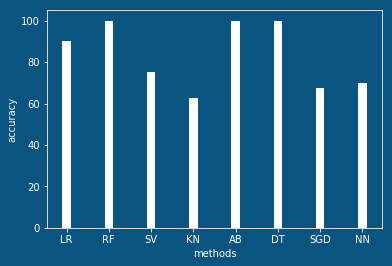

In [ ]:

import matplotlib.pyplot as plt
import matplotlib as mpl


COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

fig, ax = plt.subplots(facecolor='#095481')
# x-coordinates of left sides of bars
left = [1, 2, 3, 4, 5, 6, 7, 8]

# heights of bars
height = [LR, RF, SVM, KN, AB, DT, SGD, NN]

# labels for bars
tick_label = ['LR', 'RF', 'SV', 'KN', 'AB', 'DT', 'SGD', 'NN']

# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.2, color = ['white'])

# naming the x-axis
plt.xlabel('methods')
# naming the y-axis
plt.ylabel('accuracy')
# plot title

# for i, v in enumerate(height):
#     plt.text(left[i] - 0.30, v + 0.5, str(v))
# for i, v in enumerate(height):
#     plt.text(left[i] - 0.30, v + 0.5, str(v))

ax.set_facecolor("#095481")
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')


ax.set_clip_on(False)
# function to show the plot
plt.show()


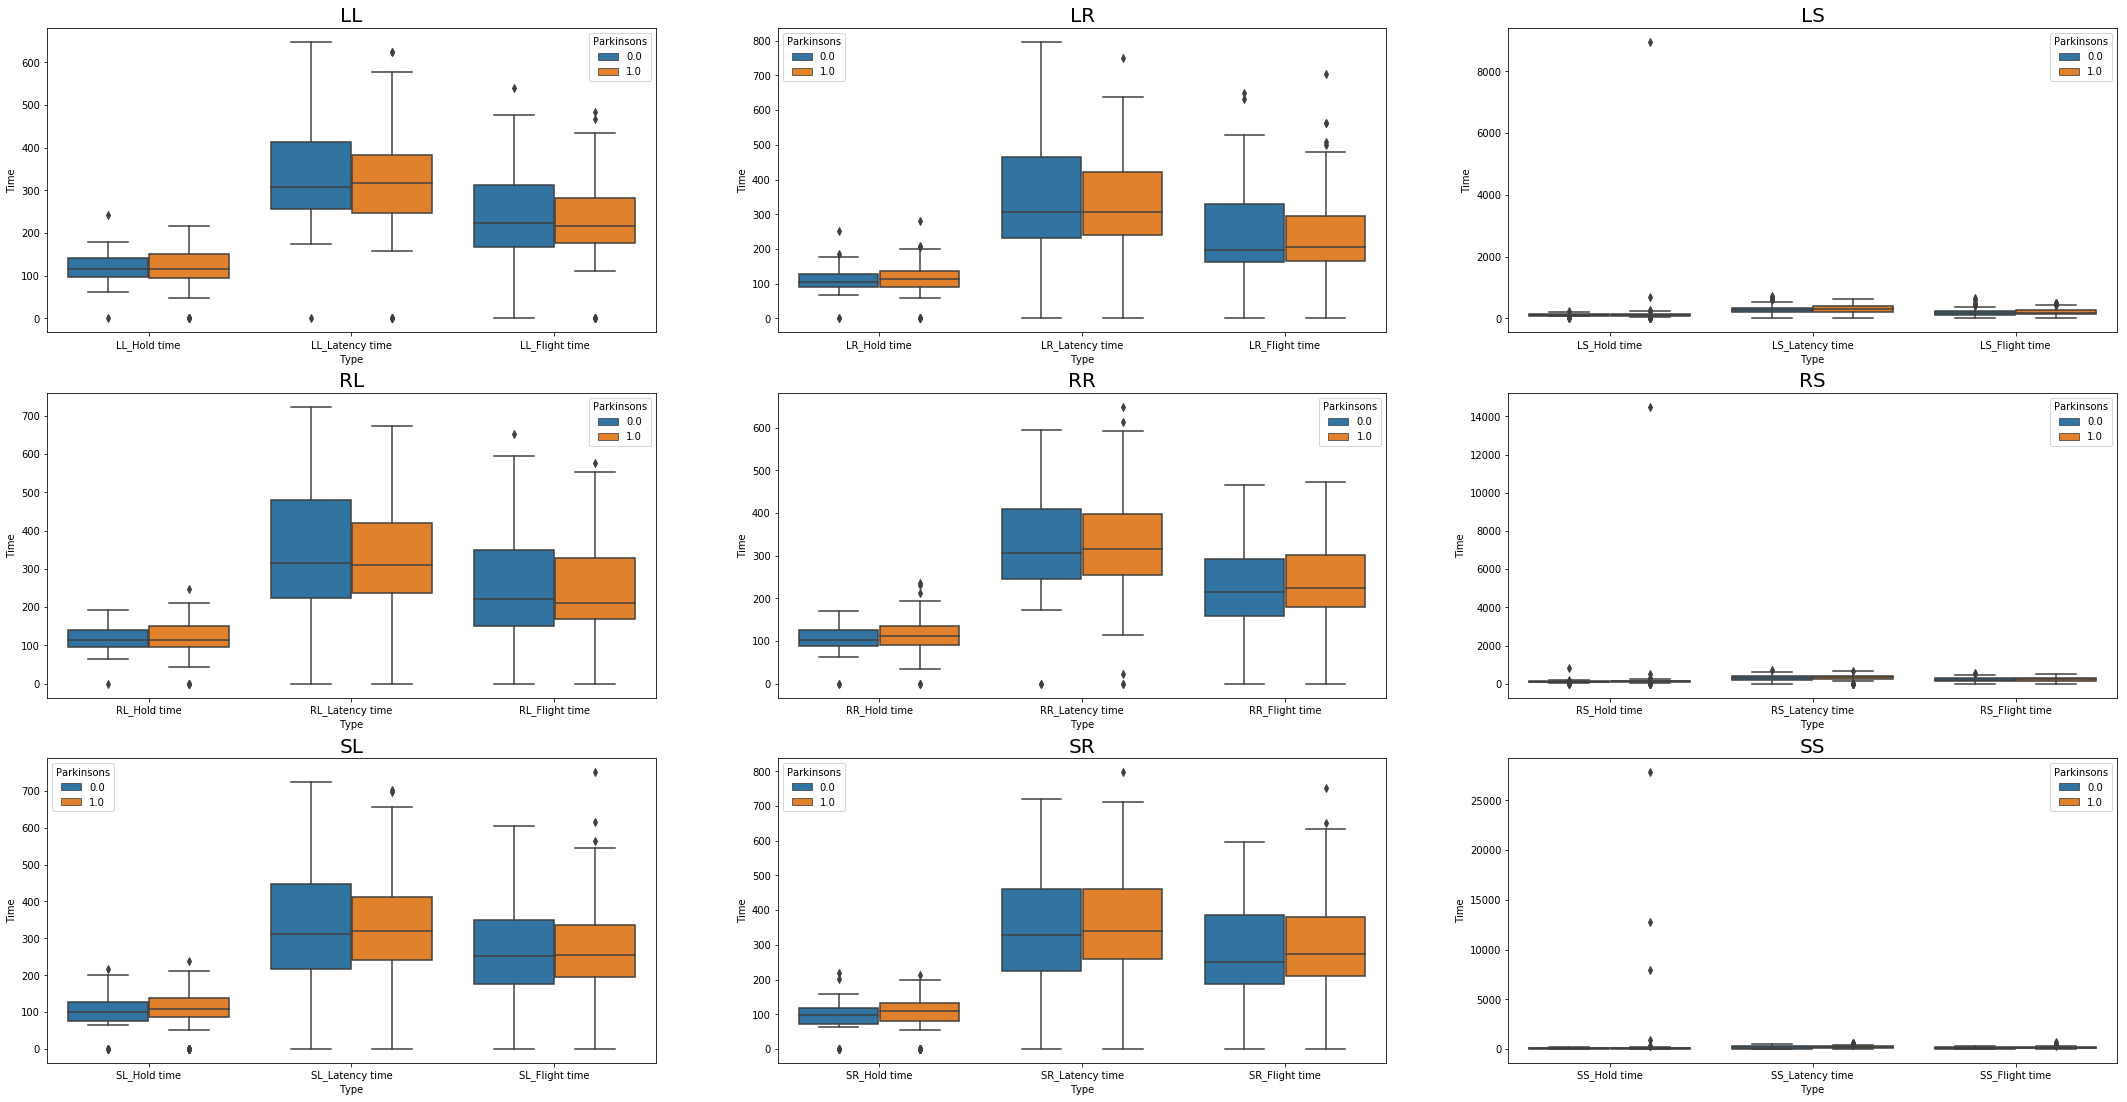

In [ ]:
f, ax = plt.subplots(3, 3, figsize=(10, 5))
#f.tight_layout()
plt.subplots_adjust(
    #left  = 0.5,
    right = 3,
    #bottom = 0.5,
    top = 3,
)

for i in range(9):
    temp_columns = column_names[3 * i : 3 * i + 3]
    stacked_df = combined_user_df[temp_columns].stack().reset_index()

    stacked_df = stacked_df.rename(columns={'level_0': 'index', 'level_1': 'Type', 0: 'Time'})
    stacked_df = stacked_df.set_index('index')

    for index in stacked_df.index:
        stacked_df.loc[index, 'Parkinsons'] = combined_user_df.loc[index, 'Parkinsons']

    sns.boxplot(x='Type', y='Time', hue='Parkinsons', data=stacked_df, ax=ax[i // 3][i % 3]).set_title(column_names[i * 3][: 2], fontsize=20)

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
